In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *

from gui.user_code import get_demsar_diagram, get_demsar_params
from gui.output_utils import *

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


In [2]:
# some generic functions 

def diff_plot(list1, list2, labels, sort_by_magnitude=True):
    """
    Compare the scores of pairs of experiment ids and plot a bar chart
    :param list1, list2: [1,2,3], [4,5,6] means exp 1 is compared to exp 4, etc ...
    :param labels: labels for the x-axis, one per pair of experiments
    :param sort_by_magnitude: if true, pairs on x-axis are sorted by magnitude of  
    difference, otherwise by order defined in `ids`
    """
    assert len(list1) == len(list2) == len(labels)
    diffs = []
    for i, (a, b) in enumerate(zip(list1, list2)):
        significance_df, names, mean_scores = get_demsar_params([a, b], 
                                                                name_format=['id', 
                                                                             'vectors__id',
                                                                             'vectors__composer',
                                                                             'vectors__algorithm',
                                                                             'vectors__dimensionality'])
        diffs.append(mean_scores[0] - mean_scores[1])
        if significance_df is None:
            continue
        if significance_df.significant[0] == 'True':
            labels[i] += '*'
    df = pd.DataFrame(dict(Model=labels, Delta=diffs))
#     df.to_html('tmp.html')
#     df.to_csv('tmp.csv')
#     df.to_csv?
    order = df.Model[df.Delta.argsort()].tolist() # seaborn doesn't like DataFrame-s here
    print(order)
    g = sns.factorplot('Model', 'Delta', data=df, kind='bar', 
                       x_order=order if sort_by_magnitude else None,
                       aspect=1.5);
    g.set_xticklabels(rotation=90);
    # remove axis labels  
    for ax in g.axes.flat:
        ax.set(xlabel='', ylabel='')
  

def _window_deps_composers_naming(mylist):
    """
    Returns names like D-Add or W-Mult for **count vectors only**
    """
    labels = []
    for id in mylist:
        feats, composer = Experiment.objects.filter(id=id).values_list('vectors__algorithm', 'vectors__composer')[0]
        label = '{}-{}'.format(feats[6].upper(), composer)
        labels.append(label)
    return labels

# word2vec vs glove

[114, 134, 124, 144] [100, 102, 101, 103]
Running significance for experiments [114, 100]
Running significance for experiments [134, 102]
Running significance for experiments [124, 101]
Running significance for experiments [144, 103]
['Mult*', 'Add*', 'Left*', 'Right*']


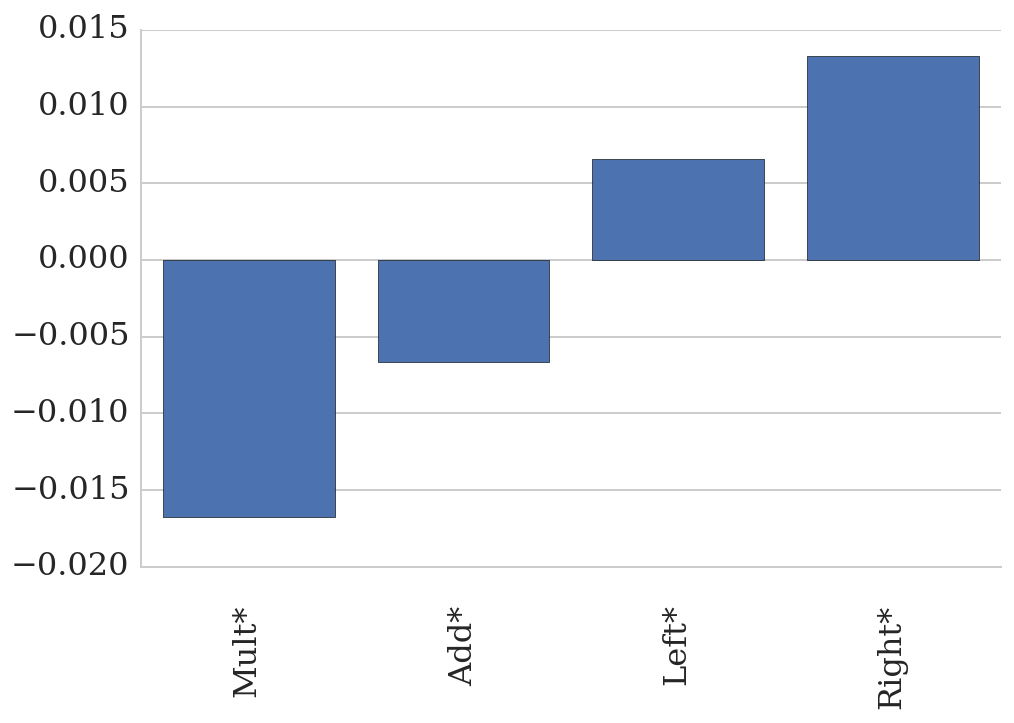

In [3]:
d = {'noise': 0.0, 
     'decode_handler': 'SignifiedOnlyFeatureHandler', 
     'k': 3, 
     'vectors__rep': 0,
     'vectors__unlabelled_percentage': 100.0,
     'vectors__unlabelled' : 'wiki',
     'labelled': 'amazon_grouped-tagged', 
     'vectors__algorithm': 'word2vec', 
     'labelled': 'amazon_grouped-tagged',
     'document_features_tr': 'J+N+AN+NN',
     'document_features_ev': 'AN+NN',
     'vectors__unlabelled_percentage':100,
     'entries_of':None,
     'vectors__composer__in': ['Add', 'Mult', 'Right', 'Left']}

w2v = [x.id for x in Experiment.objects.filter(**d).order_by('vectors__algorithm', 'vectors__composer')]
d['vectors__algorithm'] =  'glove'
glove = [x.id for x in Experiment.objects.filter(**d).order_by('vectors__algorithm', 'vectors__composer')]

print(w2v, glove)
diff_plot(w2v, glove, [Experiment.objects.get(id=id).vectors.composer for id in w2v])
plt.savefig('plot-w2v-vs-glove-deltas.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

4000 4000 4000 4000


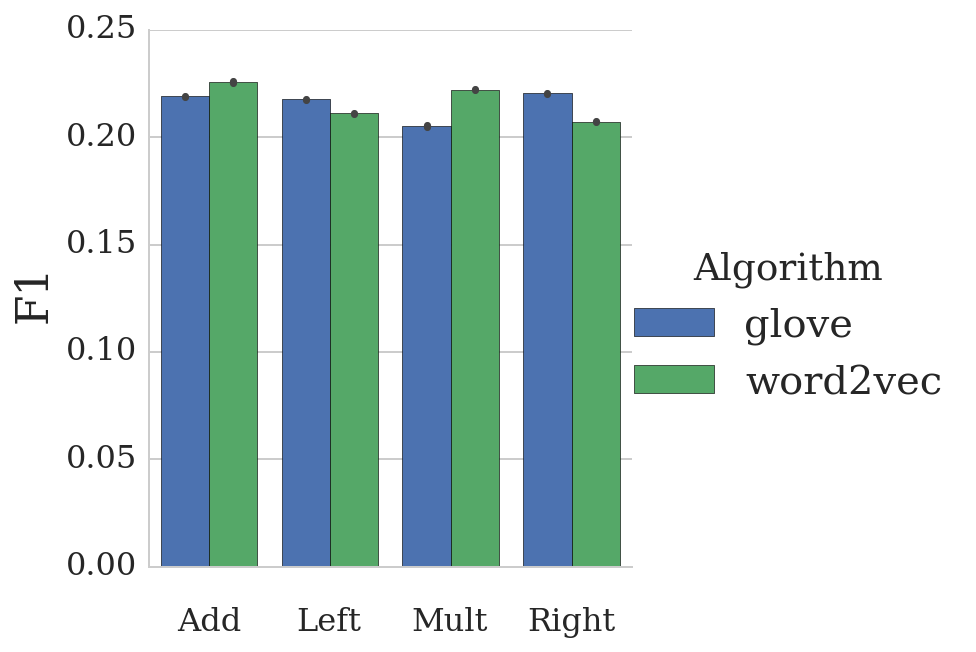

In [4]:
ids = w2v + glove
data, folds = get_cv_scores_many_experiment(ids)
composers = get_vectors_field(ids, 'composer')
algos=get_vectors_field(ids, 'algorithm')
print(len(data), len(folds), len(composers), len(algos))
df = pd.DataFrame({'F1': data,
                   'Composer': composers,
                   'cvfold': folds,
                   'Algorithm': algos})
df.to_html('tmp.html')
grid = sns.factorplot(x='Composer', y='F1', hue='Algorithm', 
                      data=df, kind='bar');
    # remove axis labels  
for ax in grid.axes.flat:
    ax.set(xlabel='')

plt.savefig('plot-w2v-vs-glove.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Effect of SVD on count vectors- NOT using models w/o SVD any more (too slow)
Let's get all count vectors and pair them by SVD, e.g. `depsAdd-noSVD` vs `depsAdd-SVD`

In [3]:
d = {'labelled': 'amazon_grouped-tagged',
     'vectors__use_ppmi': False,
     'vectors__algorithm__in': ['count_windows', 'count_dependencies'],
     'vectors__dimensionality': 0}
# ignore baroni because it's with svd only
nosvd = [x.id for x in Experiment.objects.filter(**d).exclude(vectors__composer='Baroni').order_by('vectors__composer')]
d['vectors__dimensionality'] = 100
svd = [x.id for x in Experiment.objects.filter(**d).exclude(vectors__composer='Baroni').order_by('vectors__composer')]

print(nosvd, svd)
diff_plot(nosvd, svd,  _window_deps_composers_naming(svd))
# g.axes.flat[0].set_title('NOSVD - SVD (***=significant)');
plt.savefig('plot-effect-of-svd-deltas.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

[] [5, 10, 155, 159, 175, 207, 208, 209, 210, 289, 15, 7, 12, 157, 161, 179, 6, 11, 156, 160, 177, 233, 234, 235, 236, 285, 286, 287, 288, 17, 163, 8, 13, 158, 162, 181, 9, 16, 259, 260, 261, 262]


AssertionError: 

# RESULT: 
SVD makes no difference most of the time. Not using SVD is sometimes beneficial for dependency features

# Effect of PPMI on count vectors- NOT doing PPMI currently

[] []
[]


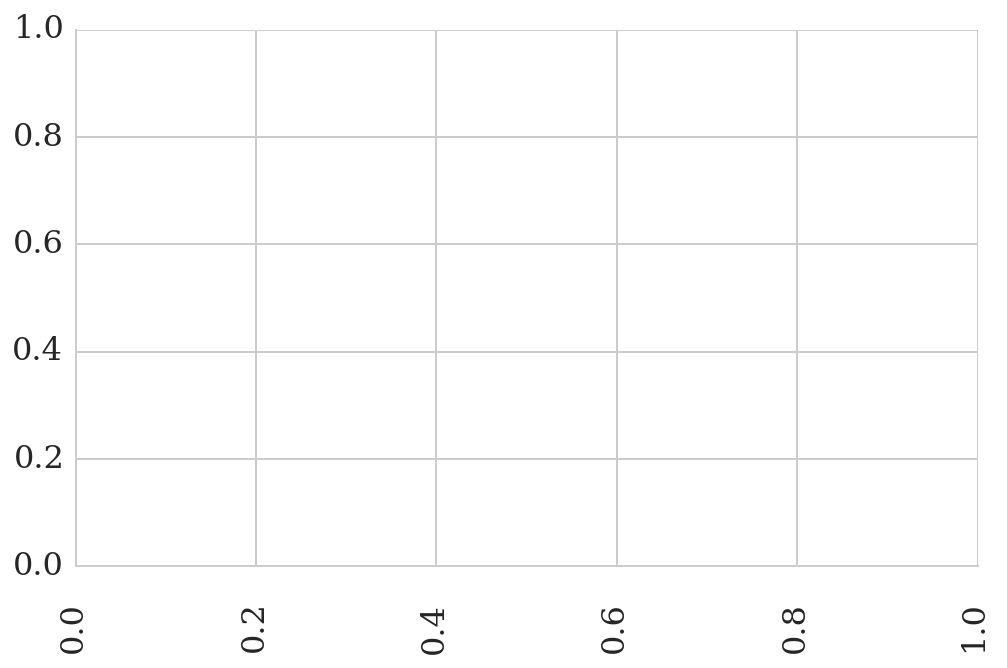

In [4]:
d = {'noise': 0.0, 
     'decode_handler': 'SignifiedOnlyFeatureHandler', 
     'k': 3, 
     'vectors__unlabelled_percentage': 100.0,
     'vectors__dimensionality': 0,
     'labelled': 'amazon_grouped-tagged', 
     'vectors__algorithm__in': ['count_windows', 'count_dependencies'], 
     'labelled': 'amazon_grouped-tagged',
     'vectors__composer__in': ['Add', 'Mult', 'Right', 'Left'],
     'vectors__use_ppmi': True}

with_ppmi = [x.id for x in Experiment.objects.filter(**d).order_by('vectors__algorithm', 'vectors__composer')]
d['vectors__use_ppmi'] =  False
wo_ppmi = [x.id for x in Experiment.objects.filter(**d).order_by('vectors__algorithm', 'vectors__composer')]
print(with_ppmi, wo_ppmi)
diff_plot(with_ppmi, wo_ppmi,  _window_deps_composers_naming(with_ppmi))
plt.savefig('plot-effect-of-ppmi-deltas.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Result
Positive value means PPMI is better, * indicates significant at 0.01 level.

Add/Mult composers definitely benefit more from PPMI, and Left/Right do not. This is interesting.